# Aligning phonemes and words to audio

In this notebook we demonstrate how to perform alignment between audio and text transcripts of a series of trials. We show two methods for performing this alignment. 

1) All the information needed for alignment can be stored in a Data object, including the sound waveform, text transcripts, and several other parameters, and the entire alignment is performed on the Data object, returning a new Data instance which has alignment information.
    
2) WAV files and .txt files for all trials are stored in specific directories and alignment is performed in 2 steps. First, these files are aligned to create .TextGrid, .phn, and .wrd files. Then these are processed to create the same alignment information as is output by method 1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import naplib as nl
from naplib.features import Aligner
from naplib.segmentation import segment_around_label_transitions

In [2]:
data = nl.io.load_speech_task_data()
len(data) # number of trials in this data

10

## Method 1: Perform full alignment pipeline on a Data instance

All sounds and transcripts as well and several other fields must be present in the Data. They will be aligned and results will be given in a new Data instance of label vectors.

In [3]:
# Specify the directory to store the output files from alignment (.TextGrid, .phn, and .wrd files)
output_dir = './alignment_output_data2'

aligner = Aligner(output_dir, tmp_dir='data2_/')

In [4]:
# the Aligner's align() method requires a length field which specifies the number of
# samples that we want each resulting label vector to contain
data['length'] = [x.shape[0] for x in data['resp']]

The "sound" field is type <class 'numpy.ndarray'> and the first trial is shape (683271,)


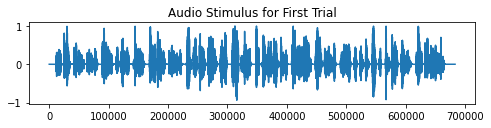

In [30]:
# Two of the other critical fields we need for alignment include the 'sound', and the 'transcript'
print(f'The "sound" field is type {type(data[0]["sound"])} and the first trial is shape {data[0]["sound"].shape}')

plt.figure(figsize=(8,1.5))
plt.plot(data[0]["sound"])
plt.title(f'Audio Stimulus for First Trial')
plt.show()


In [6]:
# This is the first trial's 'transcript', the words spoken in the trial's stimulus
data[0]["script"]

'IT IS ME AGAIN HANK THE COW DOG I JUST GOT SOME TERRIBLE NEWS THERE HAS BEEN A MURDER ON THE RANCH I KNOW I SHOULD NOT BLAME MYSELF I MEAN A DOG IS ONLY A DOG HE CANNOT BE EVERYWHERE AT ONCE WHEN I TOOK THIS JOB AS HEAD OF RANCH SECURITY I KNEW THAT I COULD ONLY RELY ON MYSELF FOUR LEGS A TAIL A COUPLE OF EARS A PRETTY NICE KIND OF NOSE TWO BUSHELS OF HAIR YOU ADD THAT ALL UP AND YOU DO NOT GET SUPERMAN JUST ME GOOD OLD EASYGOING HANK WHO WORKS HARD TRIES TO DO HIS JOB AND GETS VERY LITTLE COOPERATION FROM ANYONE ELSE AROUND HERE I AM NOT COMPLAINING I KNEW THIS WOULD NOT BE AN EASY JOB IT TOOK A SPECIAL KIND OF DOG STRONG FEARLESS DEDICATED AND ABOVE ALL SMART OBVIOUSLY DROVER DID NOT FIT THE JOB FELL ON MY SHOULDERS IT WAS MY DESTINY I COULD NOT ESCAPE THE BROOM OF HISTORY THAT SWEPT THROUGH'

In [7]:
# In this Data instance, the transcript is in a field called "script", not the default "transcript",
# so we need to specify that.
# If other required fields were named differently from their default values, we would need
# to specify those as well. See documentation for details of required fields.

result = aligner.align(data, transcript='script') # perform alignment

Resampling audio and putting in data2_/ directory...
Converting text files to ascii in data2_/ directory...
Performing alignment...
Converting .TextGrid files to .phn and .wrd in ./alignment_output_data2
Finished creating alignment files.
Creating label vectors for phonemes, manner of articulation, and words.


### Use a custom dictionary for phonemes

If there were words in our scripts that were not in the default dictionary, we can create our own dictionary file
by copying the [ProsodyLab eng.dict](https://github.com/prosodylab/Prosodylab-Aligner/blob/master/eng.dict) and adding lines for the words that we need. We can then put this new .dict file in the current path and specify it for the Aligner to use.

In [8]:
aligner = Aligner(output_dir, tmp_dir='data_/', dictionary_file='../Alignment/eng_modified.dict')

result = aligner.align(data, transcript='script')

Resampling audio and putting in data_/ directory...
Converting text files to ascii in data_/ directory...
Performing alignment...
Converting .TextGrid files to .phn and .wrd in ./alignment_output_outstruct
Finished creating alignment files.
Creating label vectors for phonemes, manner of articulation, and words.


## Method 2: Perform alignment using audio and text files

If we have the sounds and transcripts in files but not in our Data instance, we can put all sounds (.wav files) in one directory and all matching transcripts (.txt files) in another directory.

In [9]:
audio_dir = '../Alignment/sounds'
text_dir = '../Alignment/scripts'
output_dir = './alignment_output'

In [10]:
# Create aligner
# aligner = Aligner(output_dir, tmp_dir='data_/')

# Align files
# aligner.align_files(audio_dir, text_dir)

# Get resulting labels
# result = aligner.get_label_vecs_from_files(data)

Resampling audio and putting in data_/ directory...
Converting text files to ascii in data_/ directory...
Performing alignment...
Converting .TextGrid files to .phn and .wrd in ./alignment_output
Finished creating alignment files.


#### Let's look at some of the files that were created in the output_dir

In [9]:
!ls ./alignment_output_data2 | head -10

stim01.TextGrid
stim01.phn
stim01.wrd
stim02.TextGrid
stim02.phn
stim02.wrd
stim03.TextGrid
stim03.phn
stim03.wrd
stim04.TextGrid


## Visualize the label vectors we created from either method

Using either method 1 or method 2, we are left with a Data object containing fields with the alignment information. We can visualize the label vectors for phonemes, manner of articulation, and words over time for a few trials. For each trial, the sound consists of a beep followed by 4 words.

In [8]:
result.fields

['phn_labels',
 'manner_labels',
 'wrd_labels',
 'phn_label_list',
 'manner_label_list',
 'wrd_dict']

Trial 0


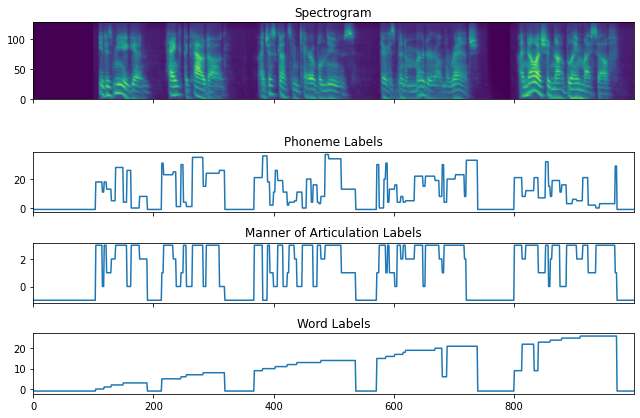

Trial 1


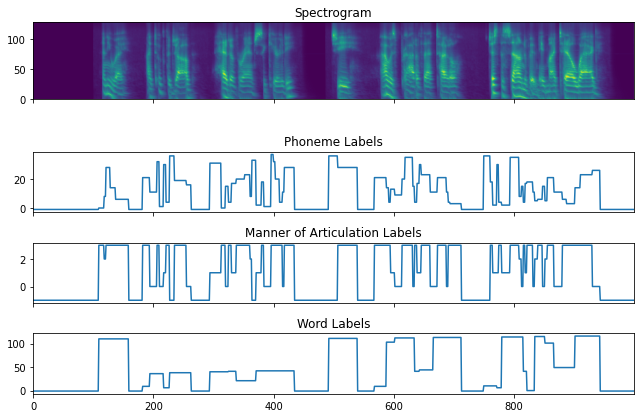

Trial 2


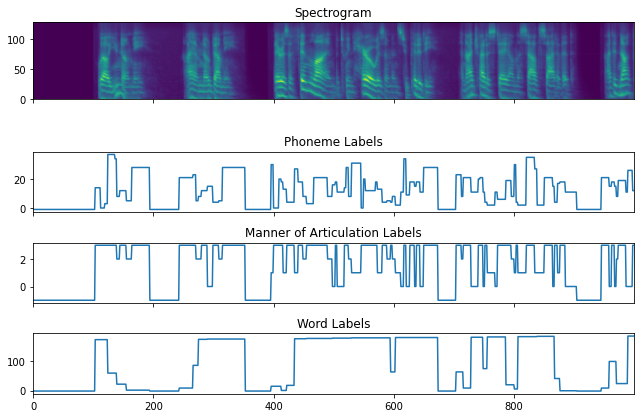

In [27]:
# Let's just look at the first 10 seconds of the first 3 trials of label vectors aligned to the stimulus

for n, trial in enumerate(data[:3]):
    
    print(f'Trial {n}')
    
    fig, axes = plt.subplots(4,1,figsize=(9,6), sharex=True, gridspec_kw={'height_ratios':[2,1,1,1]})
    
    axes[0].imshow(trial['aud'][:1000].T**.3, origin='lower', aspect=1)
    axes[0].set_title('Spectrogram')
    
    axes[1].plot(result['phn_labels'][n][:1000])
    axes[1].set_title('Phoneme Labels')
    
    axes[2].plot(result['manner_labels'][n][:1000])
    axes[2].set_title('Manner of Articulation Labels')
    
    axes[3].plot(result['wrd_labels'][n][:1000])
    axes[3].set_title('Word Labels')
    
    plt.tight_layout()
    
    plt.show()


## Looking at responses to word onsets

One simple thing we can look at using these label vectors is the neural response to word onsets.

In [23]:
segments, labels, prior_labels = segment_around_label_transitions(data, field='resp', labels=result['wrd_labels'], prechange_samples=50, postchange_samples=200)
segments, labels, prior_labels = segment_around_label_transitions(data, field='resp', labels=result['phn_labels'], prechange_samples=50, postchange_samples=200)

print(segments.shape) # num_transitions, time, num_electrodes

print(labels.shape) # num_transitions
print(prior_labels.shape) # num_transitions

(5918, 250, 10)
(5918,)
(5918,)


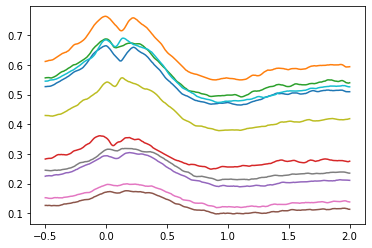

In [24]:
# plot the average phoneme-onset response for each electrode
time_vec = np.linspace(-0.5, 2, 250)
plt.figure()
plt.plot(time_vec, segments.mean(0))
plt.show()

## Compute electrode lags by phoneme f-ratio

Now that we have the alignment, one thing we can do is compute the electrode lags as measured by the peak in their f-ratio to phonemes.

In [25]:
from naplib.segmentation import electrode_lags_fratio

lags, fratios = electrode_lags_fratio(data, field='resp', labels=result['phn_labels'], max_lag=30, return_fratios=True)
fratios.shape

(10, 30)

[14 14 16  9 15 18 19 19 18 16]


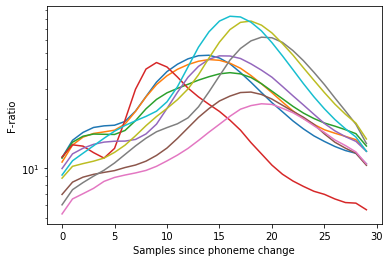

In [26]:
# We can see that the peaks in the f-ratio in separating phoneme responses is typically
# between about 100 and 200 ms after the onset of the phoneme

print(lags) # electrode lags, in samples

plt.figure()
plt.plot(fratios.T)
plt.yscale('log')
plt.ylabel('F-ratio')
plt.xlabel('Samples since phoneme change')
plt.show()